# Описание проекта

Необходимо приоретизировать гипотезы для увеличения выручки, подготовленные совместно с отделом маркетинга, и проанализировать результаты  A/B-теста.

# Описание данных

В файле hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Был проведен A/B-тест и получены результаты, которые описаны в файлах orders.csv и visitors.csv.
### Задача 1
- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE.


### Задача 2
Проанализировать A/B-тест:
- Построить график кумулятивной выручки по группам. 
- Построить график кумулятивного среднего чека по группам. 
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A. 
- Построить график кумулятивного среднего количества заказов по группам. 
- Построить график относительного изменения кумулятивного среднего количества заказов группы B к группе A. 
- Построить точечный график количества заказов по пользователям. 
- Посчитайть 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
- Построить точечный график стоимостей заказов. 
- Посчитайть 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
- Посчитайть статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. 
- Посчитайть статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
- Посчитайть статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным. 
- Посчитайть статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
- Принять решение по результатам теста. 

Файл hypothesis.csv:

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка  гипотезы.

Файл orders.csv. 

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл visitors.csv. 

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Шаг 1. Загрузка данных и подготовка к анализу

In [85]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date']) 

In [9]:
for i in [hypothesis, orders, visitors]:
    # полечение общей информации о датасете
    print(i.info())
    # поиск дубликатов
    print('Количество дубликатов:', i.duplicated().sum())
    # получение информации о количестве пропущенных значений в каждом столбце
    display('Количество пропущенных значений:', i.isna().sum())
    print('-------------------------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
Количество дубликатов: 0


'Количество пропущенных значений:'

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

-------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
Количество дубликатов: 0


'Количество пропущенных значений:'

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

-------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None
Количество дубликатов: 0


'Количество пропущенных значений:'

date        0
group       0
visitors    0
dtype: int64

-------------------------------------------------------------------


In [10]:
# приведение названий столбцов к нижнему регистру. Удаление пробелов
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

Названия столбцов приведены в нижний регистр, пробелы заменены на подчеркивание.<br>
Дубликатов нет.<br>
Пропусков нет.<br>
Столбцы с датами переведены в тип дат.

In [15]:
# просмотр уникальных значений для категориальных данных
for i in [orders['group'], visitors['group']]:
    print('Уникальные значения:', i.unique())

# минимальная дата заказа
print('Первая дата заказа:', orders['date'].min())

# максимальная дата заказа
print('Последняя дата заказа:', orders['date'].max())

# минимальная дата visitors
print('Дата регистрации первого пользователя:', visitors['date'].min())

# максимальная дата visitors
print('Дата регистрации последнего пользователя:', visitors['date'].max())

display('Количество посетителей в группах:', visitors.groupby('group').agg({'visitors':sum}))

Уникальные значения: ['B' 'A']
Уникальные значения: ['A' 'B']
Первая дата заказа: 2019-08-01 00:00:00
Последняя дата заказа: 2019-08-31 00:00:00
Дата регистрации первого пользователя: 2019-08-01 00:00:00
Дата регистрации последнего пользователя: 2019-08-31 00:00:00


'Количество посетителей в группах:'

,visitors
group,
A,18736
B,18916


В обеих таблицах даты начала теста с первого по последнее августа 2019 года.<br>
Разница в количестве посетителей между группами в 0,96% является не существенной.

In [17]:
# проверка наличия пользователей попавших в обе группы
orders.groupby('visitor_id').agg({'transaction_id': 'count', 
                                  'group': 'sum'}).sort_values(by='transaction_id', ascending=False).head()

,transaction_id,group
visitor_id,,
4256040402,11,BAAABABAABA
2458001652,11,ABBABABABBA
2378935119,9,AAABBBBAB
2038680547,8,BAAABAAB
199603092,5,AABAA


Пользователи совершившие попавшие в обе группы есть. Необходимо сосчитать их количество и оценить количество их покупок.

In [44]:
# поиск количества пользователей и заказов попавших в обе группы - вариант 1
user_check = np.intersect1d(orders.query('group == "A"')['visitor_id'], 
                            orders.query('group == "B"')['visitor_id'], 
                            assume_unique = False)

print('В обе группы попало', 
      len(user_check), 
      'пользователей, которые совершили', 
      orders.query("visitor_id in @user_check")['revenue'].count(), 
      'транзакцию')

В обе группы попало 58 пользователей, которые совершили 181 транзакцию


In [36]:
# поиск количества пользователей и заказов попавших в обе группы - вариант 2
all_a = orders[orders['group'] == 'A']
all_b = orders[orders['group'] == 'B']
all_in = all_a[['visitor_id', 'transaction_id']].merge(all_b[['visitor_id', 'transaction_id']], 
                                                       on='visitor_id', 
                                                       how='inner'
                                                      ).groupby('visitor_id').agg({'transaction_id_x': 'nunique', 
                                                                                   'transaction_id_y': 'nunique'})

print('В обе группы попало', 
      all_in['transaction_id_x'].count(), 
      'пользователей, которые совершили', 
      (all_in['transaction_id_x'].sum() + all_in['transaction_id_y'].sum()), 
      'транзакцию')

# всего заказов
print('Всего заказов:', orders['transaction_id'].count())

# всего пользователей совершивших заказ
print('Пользователей совершивших заказ:', orders['visitor_id'].nunique())

В обе группы попало 58 пользователей, которые совершили 181 транзакций
Всего заказов: 1197
Пользователей совершивших заказ: 1031


Из 1031 только 58 одинаковых пользователей в двух группах совершили 181 заказ из 1197.<br>
Что является 5,6% от пользователей и 15,1% от заказов.<br>
Это очень много. Так что принимаю решение оставить как есть.

## Шаг 2. Приоритизация гипотез
### Применение фреймворка ICE для приоритизации гипотез. 

In [52]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Применение фреймворка RICE для приоритизации гипотез. 

In [50]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Приоритизация изменилась весьма сильно. <br>
- Восьмая гипотеза ушла напятое место.<br>
- Нулевая на третье со второго.<br>
- Седьмая с третьего на первое.<br>
- Шестая и четвертая остались на своих местах.<br>
- Вторая с пятого на второе поднялась.<br>
- Первая опустилась с шестого на седьмое.<br>
- Пятая опустилась с седьмого на восьмое.<br>
<br>
Так произошло из-за введения нового коэффициента в формулу рассчета. Параметр Reach — скольких пользователей затронет изменение, которое вы хотите внести, внес свои коррективы.

## Шаг 3. Анализ A/B-теста


In [54]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

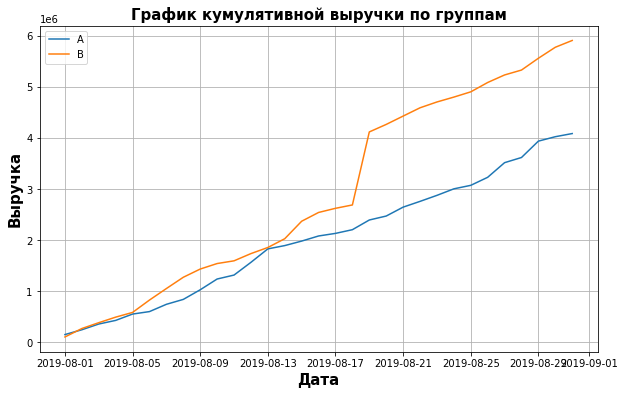

In [61]:
# построение графика кумулятивной выручки по группам
plt.figure(figsize=(10, 6))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend(loc='upper left', fontsize=10)
plt.xlabel('Дата', fontsize=15, fontweight='bold')
plt.ylabel('Выручка', fontsize=15, fontweight='bold')
plt.title('График кумулятивной выручки по группам', fontsize=15, fontweight='bold')
plt.grid()
plt.show()

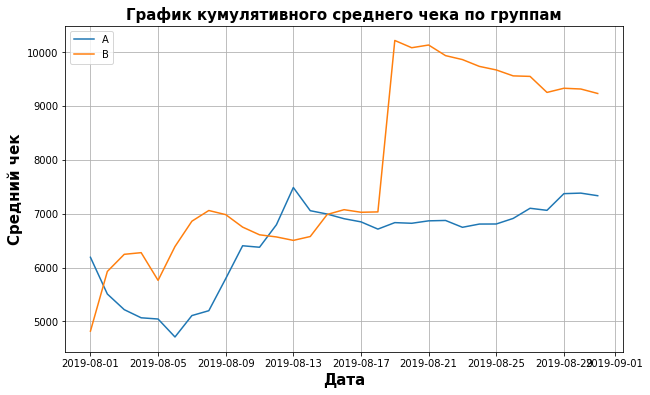

In [62]:
# построение графика кумулятивного среднего чека по группам
plt.figure(figsize=(10, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend(loc='upper left', fontsize=10)
plt.xlabel('Дата', fontsize=15, fontweight='bold')
plt.ylabel('Средний чек', fontsize=15, fontweight='bold')
plt.title('График кумулятивного среднего чека по группам', fontsize=15, fontweight='bold')
plt.grid()
plt.show()

Из графика кумулятивной выручки видно, что показатели группы В больше чем у группы А.<br>
Из графика кумулятивного среднего чека видно, что 18 августа прилетел аномально большой заказ в группу В. Это позволило ей лидировать до самого конца теста.

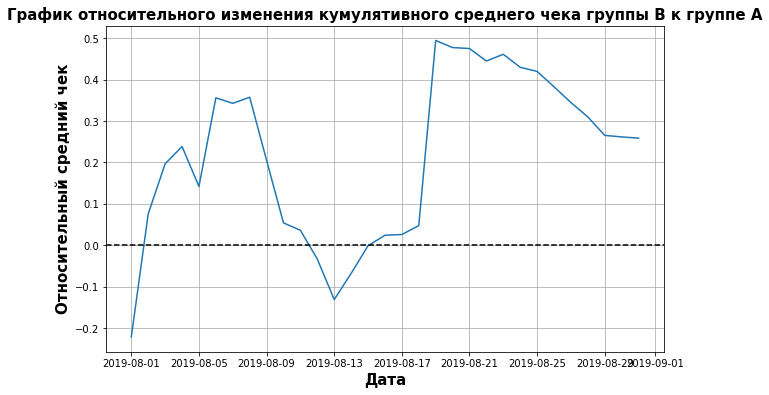

In [63]:
# построение графика относительного изменения кумулятивного среднего чека группы B к группе A
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(10, 6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/
                                           mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xlabel('Дата', fontsize=15, fontweight='bold')
plt.ylabel('Относительный средний чек', fontsize=15, fontweight='bold')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=15, fontweight='bold')
plt.grid()
plt.show()

В нескольких датах сильно меняется картина графика. Видимо в эти дни были аномальные чеки.

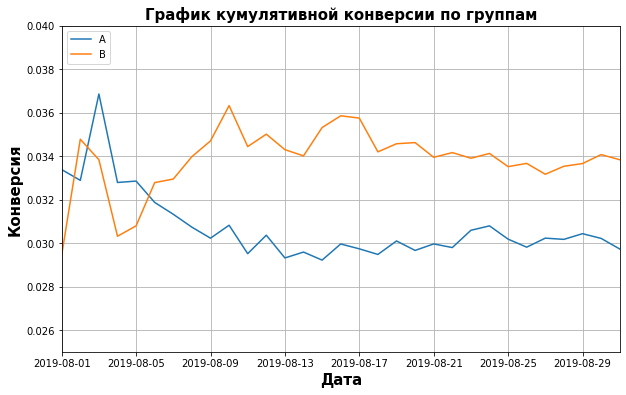

In [65]:
# построение графика кумулятивной конверсии по группам. Сделайте выводы и предположения
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(10, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend(loc='upper left', fontsize=10)

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.025, 0.04])
plt.xlabel('Дата', fontsize=15, fontweight='bold')
plt.ylabel('Конверсия', fontsize=15, fontweight='bold')
plt.title('График кумулятивной конверсии по группам', fontsize=15, fontweight='bold')
plt.grid()
plt.show()

На графике видно скачки конверсии от 2,9% до 3,7%<br>
Если в первые числа графики повторяют друг друга плюс минус, то с 5-го числа идет разнонаправленная динамика. Группа В в лидерах.

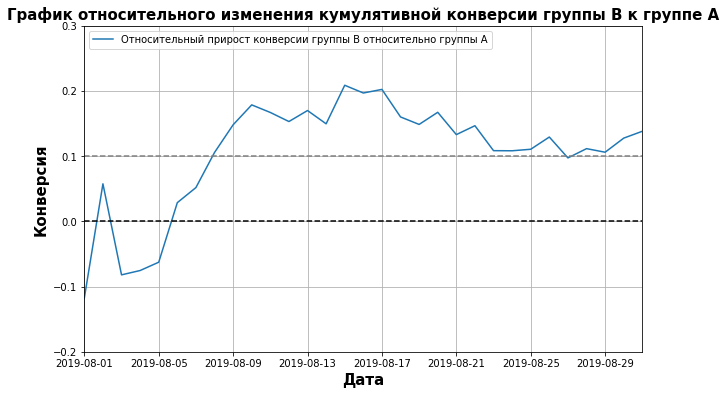

In [66]:
# построение графика относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
      left_on='date', 
      right_on='date', 
      how='left', 
      suffixes=['A', 'B'])

# строим графики
plt.figure(figsize=(10, 6))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend(loc='upper left', fontsize=10)

# задаем масштаб осей
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.2, 0.3]) 
plt.xlabel('Дата', fontsize=15, fontweight='bold')
plt.ylabel('Конверсия', fontsize=15, fontweight='bold')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize=15, fontweight='bold')
plt.grid()
plt.show() 

С 8-го числа группа В лидирует по конверсии. Стабильно зафиксировалась в диапазоне 10 - 20 %

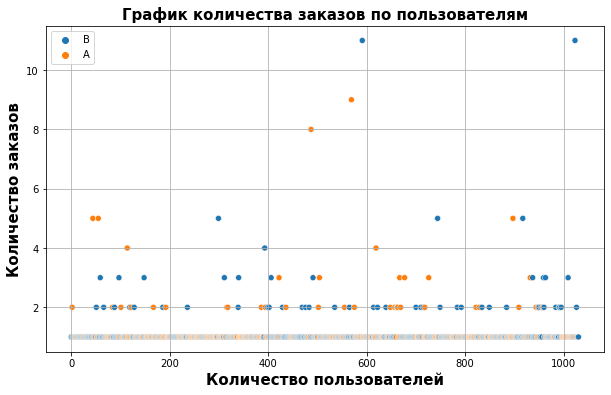

In [87]:
# построение точечного графика количества заказов по пользователям
# поиск числа заказов по пользователям
ordersByUsers = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})

# переименование столбцов
ordersByUsers.columns = ['user_id', 'orders']

# построение точечного графика количества заказов по пользователям
x_values = pd.Series(range(0,len(ordersByUsers['orders'])))
plt.figure(figsize=(10, 6))
sns.scatterplot(x_values, ordersByUsers['orders'], hue=orders['group']) 
plt.xlabel('Количество пользователей', fontsize=15, fontweight='bold')
plt.ylabel('Количество заказов', fontsize=15, fontweight='bold')
plt.title('График количества заказов по пользователям', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.show() 

Большинство пользователей сделало 1 заказ. <br>
Некоторые 2 заказа.<br>
Но есть и те кто сделал 11 заказов. И таких много.

In [97]:
#подсчет 95-го и 99-го перцентилей количества заказов на пользователя
print('Не более 5% пользователей совершали более', int(np.percentile(ordersByUsers['orders'], [95])), 'заказов')
print('---------------------------------------------------------------')
print('Не более 1% пользователей совершали более', int(np.percentile(ordersByUsers['orders'], [99])), 'заказов')

Не более 5% пользователей совершали более  2 заказов
---------------------------------------------------------------
Не более 1% пользователей совершали более  4 заказов


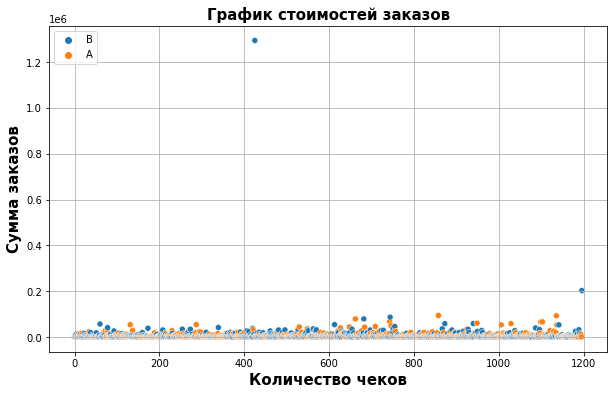

In [88]:
# построение точечного графика стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_values, y=orders['revenue'], hue=orders['group'])
plt.xlabel('Количество чеков', fontsize=15, fontweight='bold')
plt.ylabel('Сумма заказов', fontsize=15, fontweight='bold')
plt.title('График стоимостей заказов', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.show() 

In [96]:
# подсчет 95-го и 99-го перцентилей стоимости заказов. 
print('Не более 5% чеков имеют сумму более', int(np.percentile(orders['revenue'], [95])))
print('---------------------------------------------------------------')
print('Не более 1% чеков имеют сумму более', int(np.percentile(orders['revenue'], [99])))

Не более 5% чеков имеют сумму более  28000
---------------------------------------------------------------
Не более 1% чеков имеют сумму более  58233


### Подсчет статистической значимости различий в конверсии между группами по «сырым» данным. 
Я выбираю значение alpha = 0.05<br>
По конверсии были получены неоднозначные результаты. Необходимо посчитайть статистическую значимость различий в конверсии между группами по «сырым» данным.<br>
Гипотезы:<br>
Нулевая: различий в конверсии между группами нет.<br>
Альтернативная: различия в конверсии между группами есть.

In [92]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, 
                               index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - 
                                               len(ordersByUsersA['orders'])), 
                               name='orders')],
                    axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, 
                               index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - 
                                               len(ordersByUsersB['orders'])), 
                               name='orders')],
                    axis=0)

display('p-value: {0:.5f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

display('Различие в средних {0:.5f}'.format(sampleB.mean() / sampleA.mean() - 1))

'p-value: 0.01679'

'Различие в средних 0.13808'

Статистическая значимость меньше 0,05. <br>
Различие в средних 13,8%<br>
Это говорит о том, что различия есть.

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

Я выбираю значение alpha = 0.05<br>
Необходимо посчитайть статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.<br>
Гипотезы.<br>
Нулевая: различий в среднем чеке заказа между группами нет.<br>
Альтернативная: различия в среднем чеке заказа между группами есть.

In [93]:
display('p-value: {0:.4f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                            orders[orders['group']=='B']['revenue'])[1]))

display('Различие в средних {0:.4f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                                            orders[orders['group']=='A']['revenue'].mean()-1)) 

'p-value: 0.7293'

'Различие в средних 0.2587'

Статистически значимых различий нет. p-value почти 73% <br>
Различие средних чеков почти 26%<br>
Это очень много. Далее посмотрим на данные очищенные от аномалий.

### Подсчет статистической значимости различий в конверсии между группами по «очищенным» данным. 
Я выбираю значение alpha = 0.05<br>
По конверсии были получены неоднозначные результаты. Необходимо посчитайть статистическую значимость различий в конверсии между группами по «очищенным» данным.<br>
Гипотезы.<br>
Нулевая: различий в конверсии между группами нет. <br>
Альтернативная: различия в конверсии между группами есть.<br>

Больше 2 заказов и больше 28 000 стоимость - критические значения, соответствующие 95-м процентилям.

In [99]:
# создаем список пользователей с аномальными заказами
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(ordersByUsers['orders'], [95]))]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(ordersByUsers['orders'], [95]))]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], [95]))]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [100]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - 
                                               len(ordersByUsersA['orders'])), 
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(visitors[visitors['group']=='B']['visitors'].sum()- len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print('p-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Различие в средних {0:.5f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.01304
Различие в средних 0.17270


Статистическая значимость меньше 0,05. <br>
Различие в средних 17%<br>
Это говорит о том, что различия есть.

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным. 
Я выбираю значение alpha = 0.05<br>
Необходимо посчитайть статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.<br>
Гипотезы.<br>
Нулевая: различий в среднем чеке заказа между группами нет.<br>
Альтернативная: различия в среднем чеке заказа между группами есть.

In [101]:
display(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

display(
    'Различие в средних{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

'p-value: 0.738'

'Различие в средних-0.020'

Статистически значимых различий нет. p-value почти 73% <br>
Различие средних чеков теперь меньше нуля - минус 2% <br>
Это говорит о том, что много больших и повторных заказов было в группе В. Но на статистически значимые различия их влияния нет.

По результатам теста видно следующее:
- Статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий имеется. 
- Статистическая значимость различий в среднем чеке заказа между группами отсутствует как до, так и после фильтрации аномалий.
- График относительного изменения кумулятивной конверсии группы B к группе A показывает стабильное состояние группы В в диапазоне 10 - 20 %
- График относительного изменения кумулятивного среднего чека группы B к группе A колеблется. По нему сделать выводы нельзя.

По результатам теста можно сделать вывод:<br>
Преимущество группы В над группой А имеется. Тест имеет смысл прекратить.

# Шаг 4. Выводы

В Шаге 2 проекта был сделана приоретизация гипотез фреймворками ICE и RICE. Были объяснены полученные раличия.<br>
В Шаге 3 был проанализирован А/В тест.<br>
Были проведены сравнения конверсий и средних чеков групп. <br>
Были выявлены аномальные значения в целом по результатам собранных данных. <br>
В результате мы получили следующее:
- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- Статистическая значимость различий в среднем чеке заказа между группами отсутствует как до, так и после фильтрации аномалий.
- График относительного изменения кумулятивной конверсии группы B к группе A показывает стабильное состояние группы В в диапазоне 10 - 20 %
- На графике относительного изменения кумулятивного среднего чека группы B к группе A видны вбросы больших данных. По нему было принято решение о поиске аномалий. 

После сравнения данных с аномалиями и без было принято решение тест прекратить. 